# Corrections from SIDI MC + GEMC
calculations by Jason M. P.

last edit June-10, 2023

## Imports and definitions

In [3]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;

Welcome to JupyROOT 6.26/06
Loaded bin migration and acceptance weights from MC calculations.


In [4]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

In [5]:
import ROOT 

# (1) Copy the correction-application code from sidis_analysis_tools.py 

In [6]:
# bin-migration and acceptance corrections in bins of xB,Q2,z
MCCorrections_binWidth_xB = 0.05;
MCCorrections_binCenters_xB = np.arange(0.125,0.625,0.05); MCCorrections_Nbins_xB = len(MCCorrections_binCenters_xB); 

MCCorrections_binWidth_Q2 = 0.5;
MCCorrections_binCenters_Q2 = np.arange(2.25,8.25,0.5);    MCCorrections_Nbins_Q2 = len(MCCorrections_binCenters_Q2); 

MCCorrections_binWidth_z  = 0.05;
MCCorrections_binCenters_z  = np.arange(0.325,1.25,0.05);  MCCorrections_Nbins_z  = len(MCCorrections_binCenters_z);  

BinMigrationWeights_pips = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
BinMigrationWeights_pims = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
AcceptanceWeights_pips   = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
AcceptanceWeights_pims   = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])

In [12]:


# Compute beam-charge weights for each run of 1/beam-charge
# such that event yields are measured in 1/nC
beam_charge_all_runs = pd.read_csv('/Users/erezcohen/Desktop/data/BAND/metaData/rgb_all_runs.csv');
weight_per_run = np.zeros(np.max(beam_charge_all_runs.runnum)+1)
for run in beam_charge_all_runs.runnum:
    weight_per_run[run] = 1./float(beam_charge_all_runs[beam_charge_all_runs.runnum==run].iloc[0]['Beam Charge [nC]']);
    
beam_charge_all_runs_rga = pd.read_csv('/Users/erezcohen/Desktop/data/BAND/metaData/rga_all_runs.csv');
weight_per_run_rga = np.zeros(np.max(beam_charge_all_runs_rga.runnum)+1)
for run in beam_charge_all_runs_rga.runnum:
    weight_per_run_rga[run] = 1./float(beam_charge_all_runs_rga[beam_charge_all_runs_rga.runnum==run].beam_charge);

      
    
# Get bin-migration and acceptance weights in 2D (p-theta) in bins of xB,Q2,z from MC calculations by Jason
corrections_data_path = '/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/MC/Acceptance_Corrections/JasonAcceptanceCorrections/acceptance_match_2d/'
filename_acceptance_corr_pips   = corrections_data_path + 'acceptance_map_piplus_hists.root'
filename_acceptance_corr_pims   = corrections_data_path + 'acceptance_map_piminus_hists.root'
filename_binmigration_corr      = corrections_data_path + 'bin_migration_hists.root'
filename_mesonsubtraction       = corrections_data_path + 'rho_correction_hists.root'




# bin-migration and acceptance corrections in bins of xB,Q2,z
BinMigrationWeights     = dict();
AcceptanceWeights       = dict();
MesonSubtractionWeights = dict();
BinMigrationWeights['piplus']        = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
BinMigrationWeights['piminus']       = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
AcceptanceWeights['piplus']          = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
AcceptanceWeights['piminus']         = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
MesonSubtractionWeights['piplus']    = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
MesonSubtractionWeights['piminus']   = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])





# Get bin-migration, acceptance, and meson-subtraction weights in bins of xB,Q2,z from MC calculations by Jason
f_binmigration = ROOT.TFile.Open( filename_binmigration_corr,"READ" )
hBinMigrationWeights_pips = f_binmigration.Get("hWeights_p")
hBinMigrationWeights_pims = f_binmigration.Get("hWeights_m")


f3 = ROOT.TFile.Open( filename_acceptance_corr_pips,"READ" )
hAcceptanceWeights_pips = f3.Get("hWeights")
f4 = ROOT.TFile.Open( filename_acceptance_corr_pims,"READ" )
hAcceptanceWeights_pims = f4.Get("hWeights")

f_mesonsubtraction = ROOT.TFile.Open( filename_mesonsubtraction,"READ" )
hMesonSubtractionWeights_pips = f_mesonsubtraction.Get("hWeights_p")
hMesonSubtractionWeights_pims = f_mesonsubtraction.Get("hWeights_m")

    
    
for bin_x in range(MCCorrections_Nbins_xB): #{
    for bin_Q2 in range(MCCorrections_Nbins_Q2): #{
        for bin_z in range(MCCorrections_Nbins_z): #{
            # In root, the zeroeth bin is the "underflow bin," so it is not filled. Basically, the first actual bin will have index 1
            BinMigrationWeights['piplus'] [bin_x][bin_Q2][bin_z] = hBinMigrationWeights_pips.GetBinContent(bin_x+1, bin_Q2+1, bin_z+1)
            BinMigrationWeights['piminus'][bin_x][bin_Q2][bin_z] = hBinMigrationWeights_pims.GetBinContent(bin_x+1, bin_Q2+1, bin_z+1)
            AcceptanceWeights['piplus']   [bin_x][bin_Q2][bin_z] = hAcceptanceWeights_pips.GetBinContent  (bin_x+1, bin_Q2+1, bin_z+1)
            AcceptanceWeights['piminus']  [bin_x][bin_Q2][bin_z] = hAcceptanceWeights_pims.GetBinContent  (bin_x+1, bin_Q2+1, bin_z+1)            

            MesonSubtractionWeights['piplus']   [bin_x][bin_Q2][bin_z] = hMesonSubtractionWeights_pips.GetBinContent  (bin_x+1, bin_Q2+1, bin_z+1)
            MesonSubtractionWeights['piminus']  [bin_x][bin_Q2][bin_z] = hMesonSubtractionWeights_pims.GetBinContent  (bin_x+1, bin_Q2+1, bin_z+1)            

        #}
    #}
#}            
print('Loaded bin migration and acceptance weights from MC calculations.')



# limit corrections to a reasonable range between 0.3 - 3
# and all corrections that are outside this range will be set to zero
w_min_correction = 0.1
w_max_correction = 10.0
for pi_ch in pi_charge_names: #{
    
    BinMigrationWeights[pi_ch][BinMigrationWeights[pi_ch] < w_min_correction] = 0
    BinMigrationWeights[pi_ch][w_max_correction < BinMigrationWeights[pi_ch]] = 0
    
    AcceptanceWeights[pi_ch][AcceptanceWeights[pi_ch] < w_min_correction] = 0
    AcceptanceWeights[pi_ch][w_max_correction < AcceptanceWeights[pi_ch]] = 0

    MesonSubtractionWeights[pi_ch][MesonSubtractionWeights[pi_ch] < w_min_correction] = 0
    MesonSubtractionWeights[pi_ch][w_max_correction < MesonSubtractionWeights[pi_ch]] = 0

#}

Loaded bin migration and acceptance weights from MC calculations.


# (2) Plot correction weights

### (2.1) 1D corrections in one $x_B$ and $Q^2$ bin

In [35]:
corr_pips = BinMigrationWeights['piplus']
corr_pims = BinMigrationWeights['piminus']
ylabel = "$\\frac{\\left(N^{Born}_{accepted}\\right)^{gen-kin} }{ \\left(N^{Born}_{accepted}\\right)^{rec-kin} }$"
# corr_pips = AcceptanceWeights['piplus']
# corr_pims = AcceptanceWeights['piminus']
# ylabel = "$\\frac{\\left(N^{Born}_{generated}\\right)^{gen-kin} }{ \\left(N^{Born}_{accepted}\\right)^{gen-kin}}$"

/var/folders/b4/rpy8fcnx1yx951cj3jxv3cm80000gn/T/ipykernel_2262/3760547397.py:9: RuntimeWarning: invalid value encountered in divide
  R = corr_pips[bin_x,bin_Q2,:] / corr_pims[bin_x,bin_Q2,:];


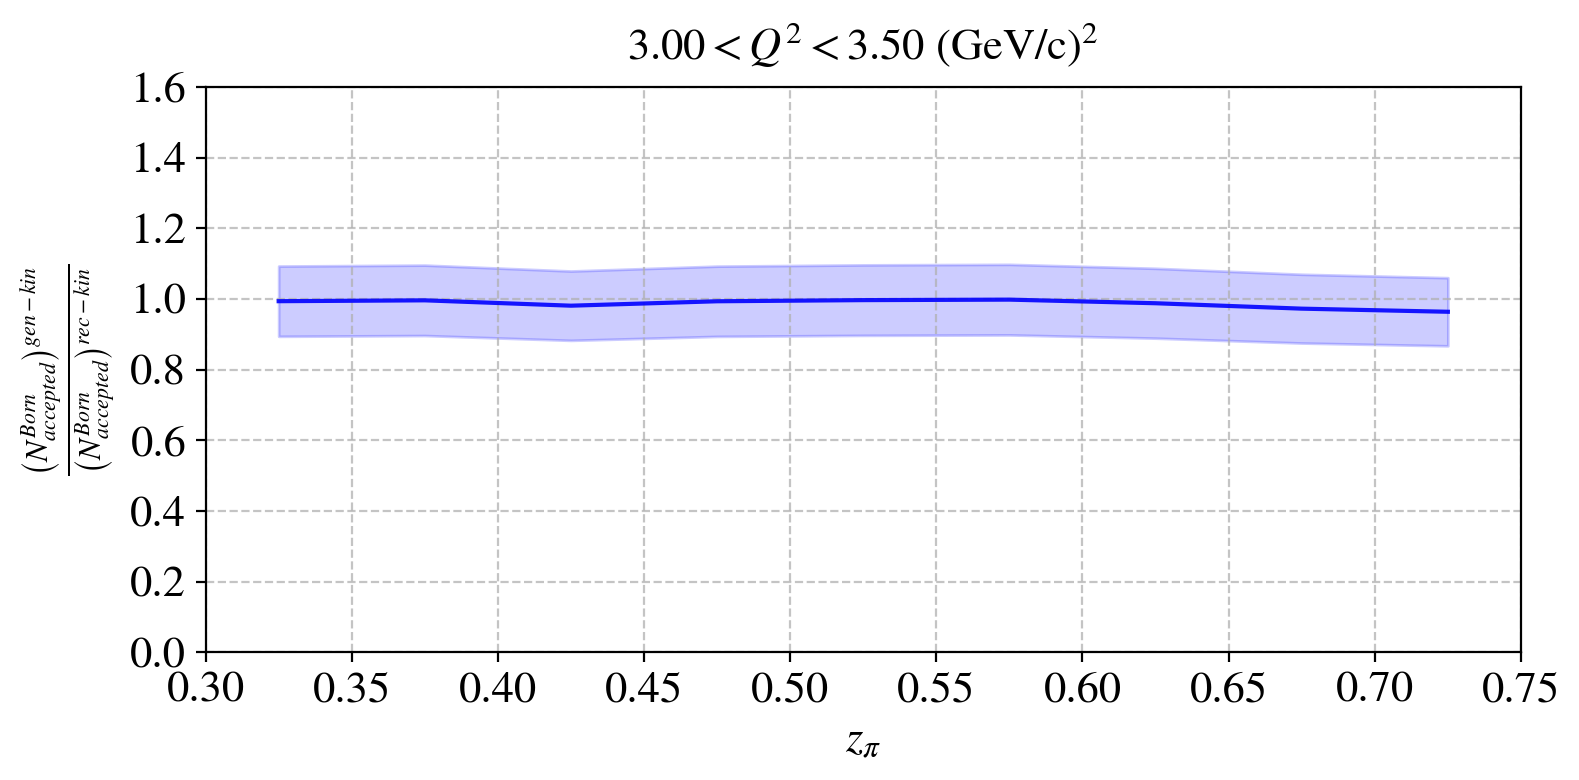

In [37]:
bin_Q2 = 2; Q2_center = MCCorrections_binCenters_Q2[bin_Q2]
Q2_min, Q2_max = Q2_center - MCCorrections_binWidth_Q2/2, Q2_center + MCCorrections_binWidth_Q2/2
bin_x = 4;  xB_center = MCCorrections_binCenters_xB[bin_x]
xB_min, xB_max = xB_center - MCCorrections_binWidth_xB/2, xB_center + MCCorrections_binWidth_xB/2
ylim=(0,1.6)
fig = plt.figure(figsize=(8,4),tight_layout=True)    
ax = fig.add_subplot(1,1,1)

R = corr_pips[bin_x,bin_Q2,:] / corr_pims[bin_x,bin_Q2,:];
plt.plot( MCCorrections_binCenters_z, R, color='blue', alpha=0.9)
plt.fill_between( MCCorrections_binCenters_z, R-0.1*R, R+0.1*R, color='blue', alpha=0.2)


set_axes(ax,'$z_{\pi}$',
         ylabel,
         title='$%.2f<Q^2<%.2f$ (GeV/c)$^2$'%(Q2_min, Q2_max),
         xlim=(0.3,0.75), ylim=ylim, do_add_legend=False, do_add_grid=True,fontsize=16,);

### (2.2) 1D AcceptanceWeights

In [57]:
arr2Plot = AcceptanceWeights['piplus']

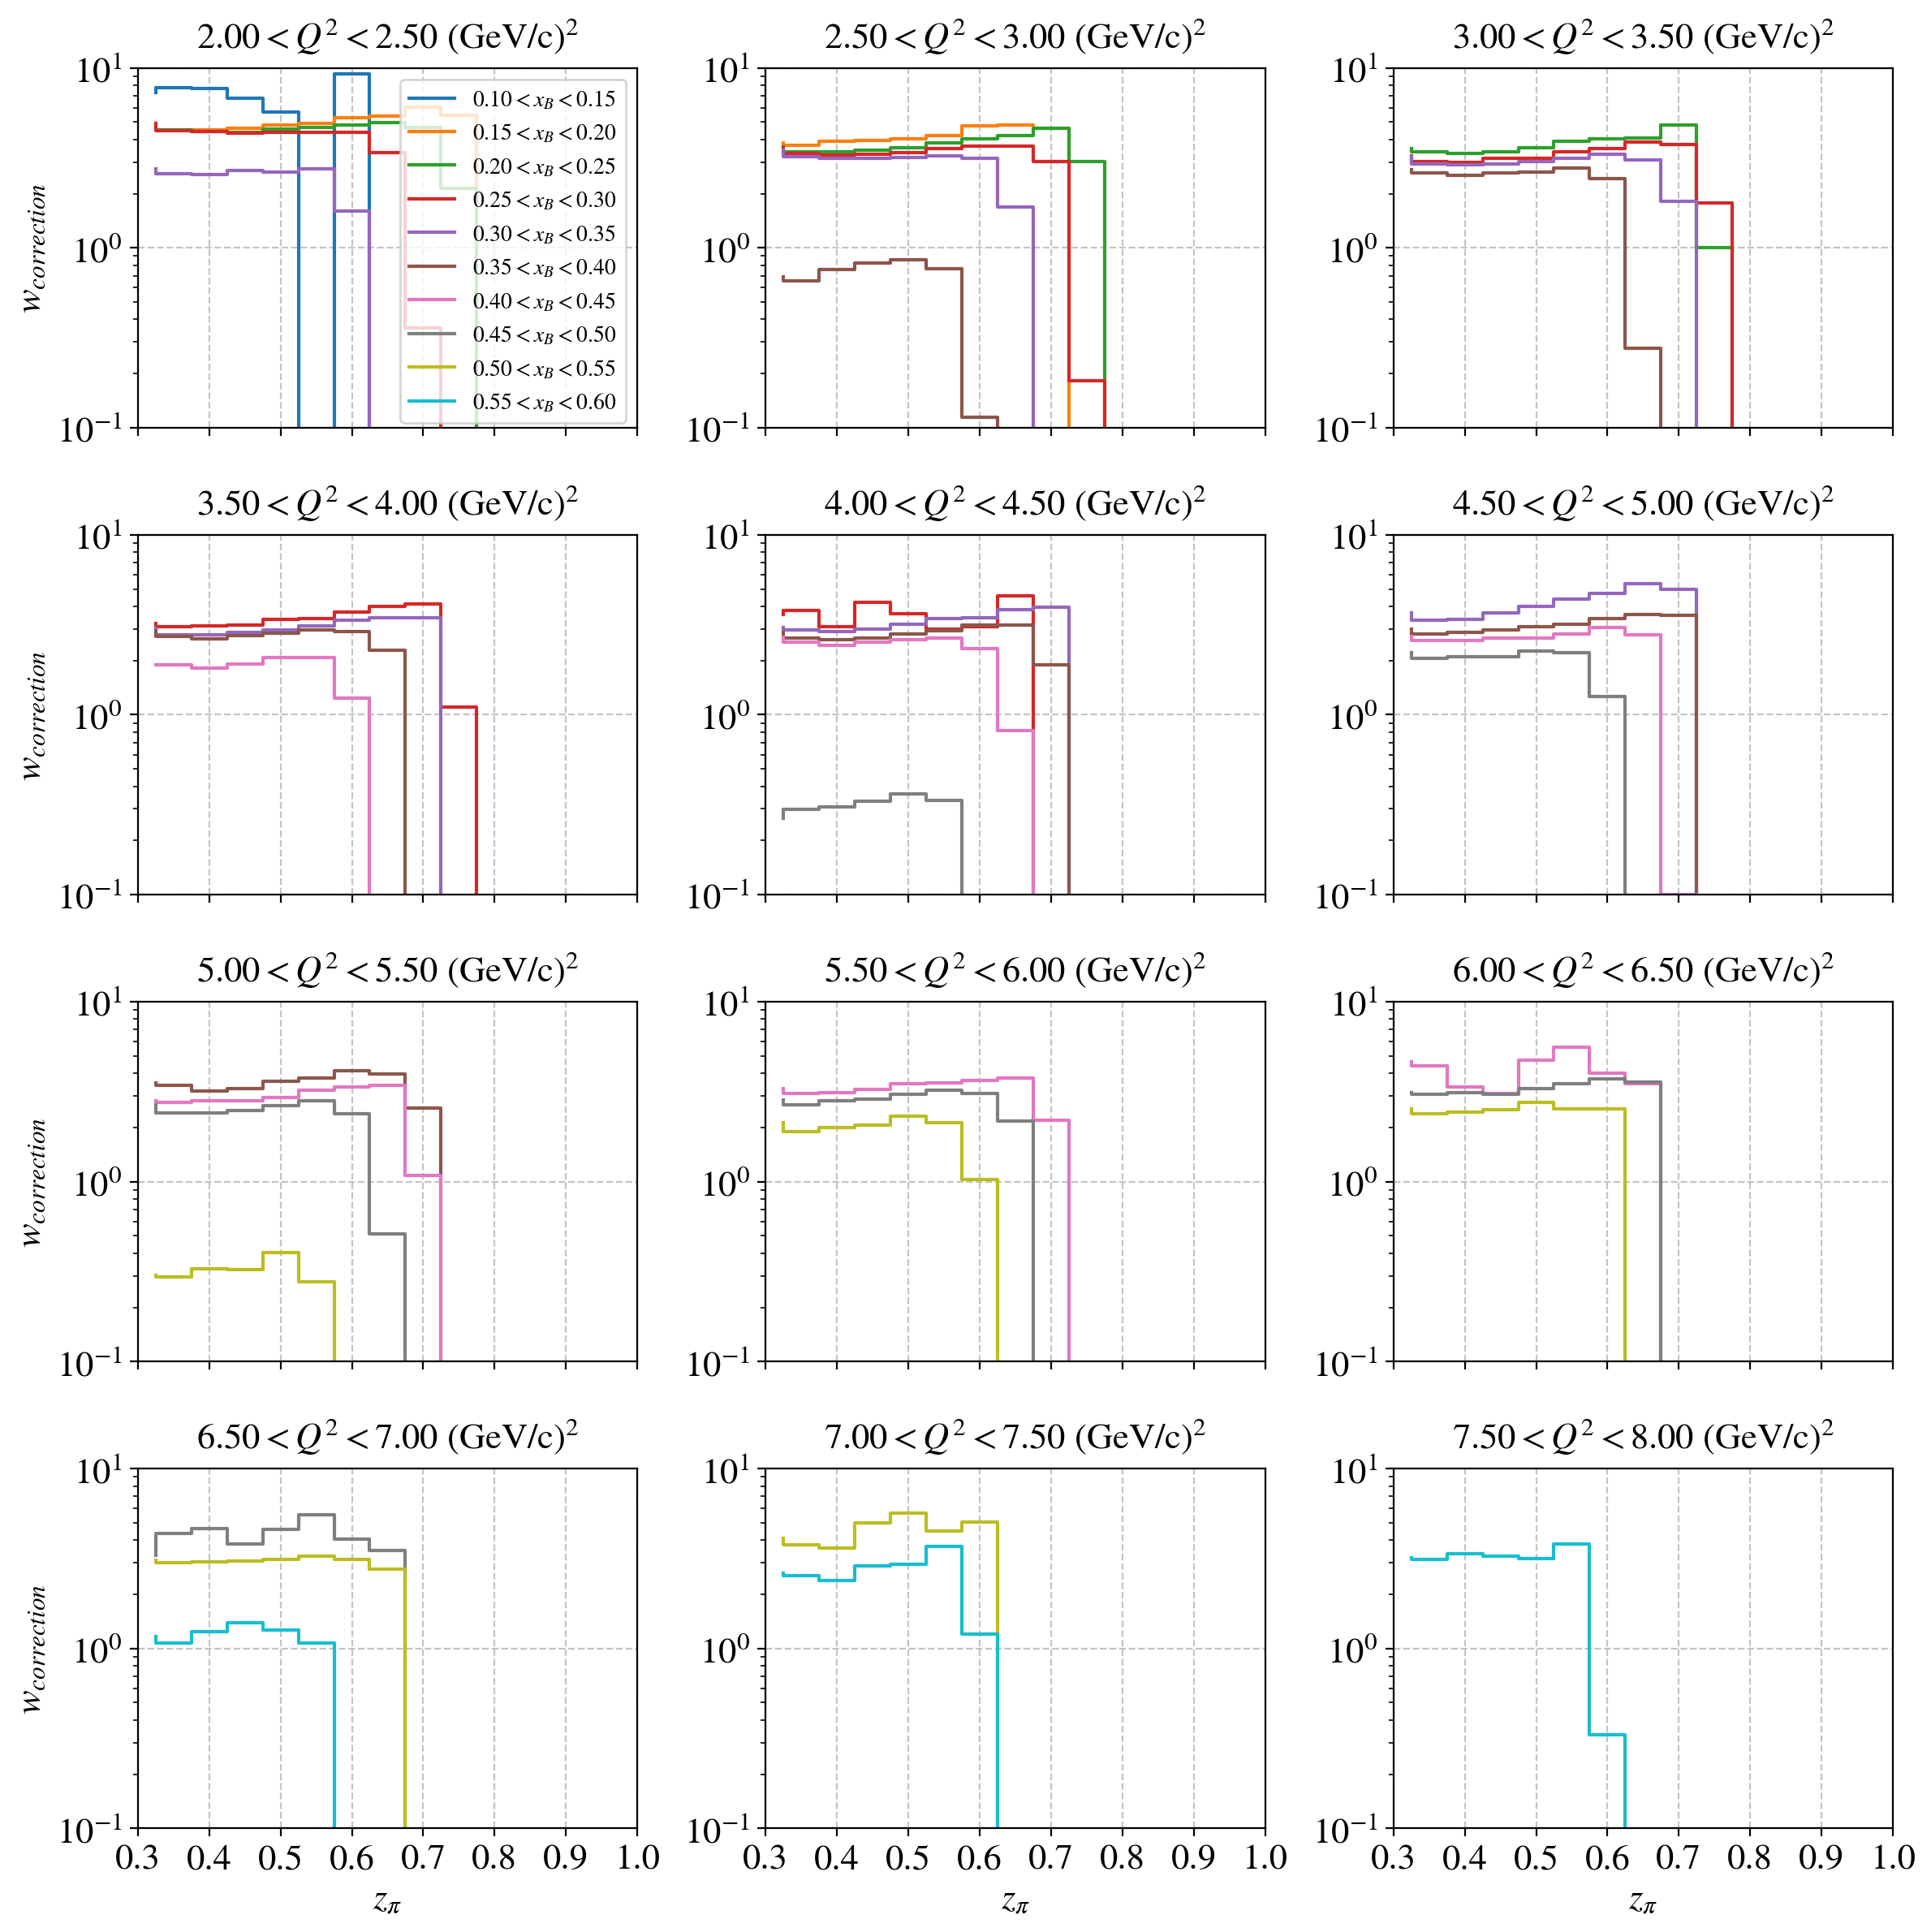

In [58]:
ylim=(1e-1,1e1)
fig = plt.figure(figsize=(12,12),tight_layout=True)
for bin_Q2 in range(MCCorrections_Nbins_Q2):
    Q2_center = MCCorrections_binCenters_Q2[bin_Q2]
    Q2_min, Q2_max = Q2_center - MCCorrections_binWidth_Q2/2, Q2_center + MCCorrections_binWidth_Q2/2
    
    ax = fig.add_subplot(4,3,bin_Q2+1)        
    for bin_x in range(MCCorrections_Nbins_xB):
        xB_center = MCCorrections_binCenters_xB[bin_x]
        xB_min, xB_max = xB_center - MCCorrections_binWidth_xB/2, xB_center + MCCorrections_binWidth_xB/2

        r = arr2Plot[bin_x,bin_Q2,:];
        plt.step( MCCorrections_binCenters_z, r, label='$%.2f<x_B<%.2f$'%(xB_min, xB_max))
    
    set_axes(ax,'$z_{\pi}$' if bin_Q2>=9 else '',
             '$w_{correction}$' if bin_Q2%3==0 else '',
             remove_ticks_x=False if bin_Q2>=9 else True,
             remove_ticks_y=False if bin_Q2%3==0 else True,
             title='$%.2f<Q^2<%.2f$ (GeV/c)$^2$'%(Q2_min, Q2_max),
             xlim=(0.3,1),
             ylim=ylim,
             do_add_legend=False, do_add_grid=True,fontsize=16,)
    
    ax.set_yscale('log')
    if bin_Q2==0: ax.legend(fontsize=10)

### (2.3) 1D meson subtraction correction

/var/folders/b4/rpy8fcnx1yx951cj3jxv3cm80000gn/T/ipykernel_14668/1271241959.py:9: RuntimeWarning: invalid value encountered in divide
  R = MesonSubtractionWeights['piplus'][bin_x,bin_Q2,:] / MesonSubtractionWeights['piminus'][bin_x,bin_Q2,:];


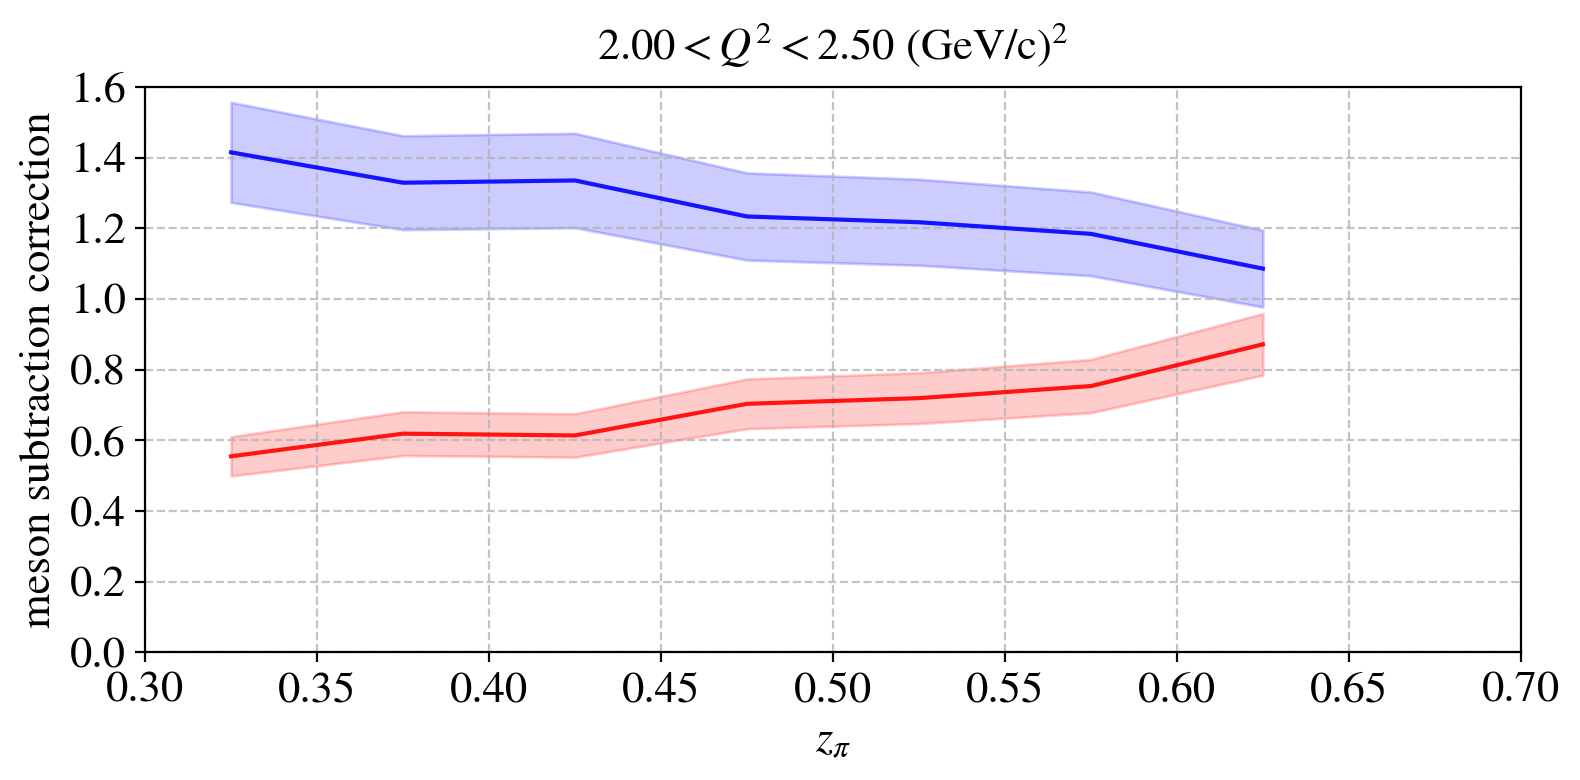

In [60]:
bin_Q2 = 0; Q2_center = MCCorrections_binCenters_Q2[bin_Q2]
Q2_min, Q2_max = Q2_center - MCCorrections_binWidth_Q2/2, Q2_center + MCCorrections_binWidth_Q2/2
bin_x = 4;  xB_center = MCCorrections_binCenters_xB[bin_x]
xB_min, xB_max = xB_center - MCCorrections_binWidth_xB/2, xB_center + MCCorrections_binWidth_xB/2
ylim=(0,1.6)
fig = plt.figure(figsize=(8,4),tight_layout=True)    
ax = fig.add_subplot(1,1,1)

R = MesonSubtractionWeights['piplus'][bin_x,bin_Q2,:] / MesonSubtractionWeights['piminus'][bin_x,bin_Q2,:];
r = (4-R)/(4*R-1)
# plt.step( MCCorrections_binCenters_z, r,  where='mid')
# plt.step( MCCorrections_binCenters_z, r-0.1*r,'--', where='mid', color='blue', alpha=0.2)
# plt.step( MCCorrections_binCenters_z, r+0.1*r,'--', where='mid', color='blue', alpha=0.2)
plt.plot( MCCorrections_binCenters_z, R, color='blue', alpha=0.9)
plt.fill_between( MCCorrections_binCenters_z, R-0.1*R, R+0.1*R, color='blue', alpha=0.2)

plt.plot( MCCorrections_binCenters_z, r, color='red', alpha=0.9)
plt.fill_between( MCCorrections_binCenters_z, r-0.1*r, r+0.1*r, color='red', alpha=0.2)



set_axes(ax,'$z_{\pi}$',
         'meson subtraction correction',
         title='$%.2f<Q^2<%.2f$ (GeV/c)$^2$'%(Q2_min, Q2_max),
         xlim=(0.3,0.7), ylim=ylim, do_add_legend=False, do_add_grid=True,fontsize=16,);

### (2.1.3) 1D bin migration

/var/folders/b4/rpy8fcnx1yx951cj3jxv3cm80000gn/T/ipykernel_14668/1809727660.py:9: RuntimeWarning: invalid value encountered in divide
  R = BinMigrationWeights['piplus'][bin_x,bin_Q2,:] / BinMigrationWeights['piminus'][bin_x,bin_Q2,:];


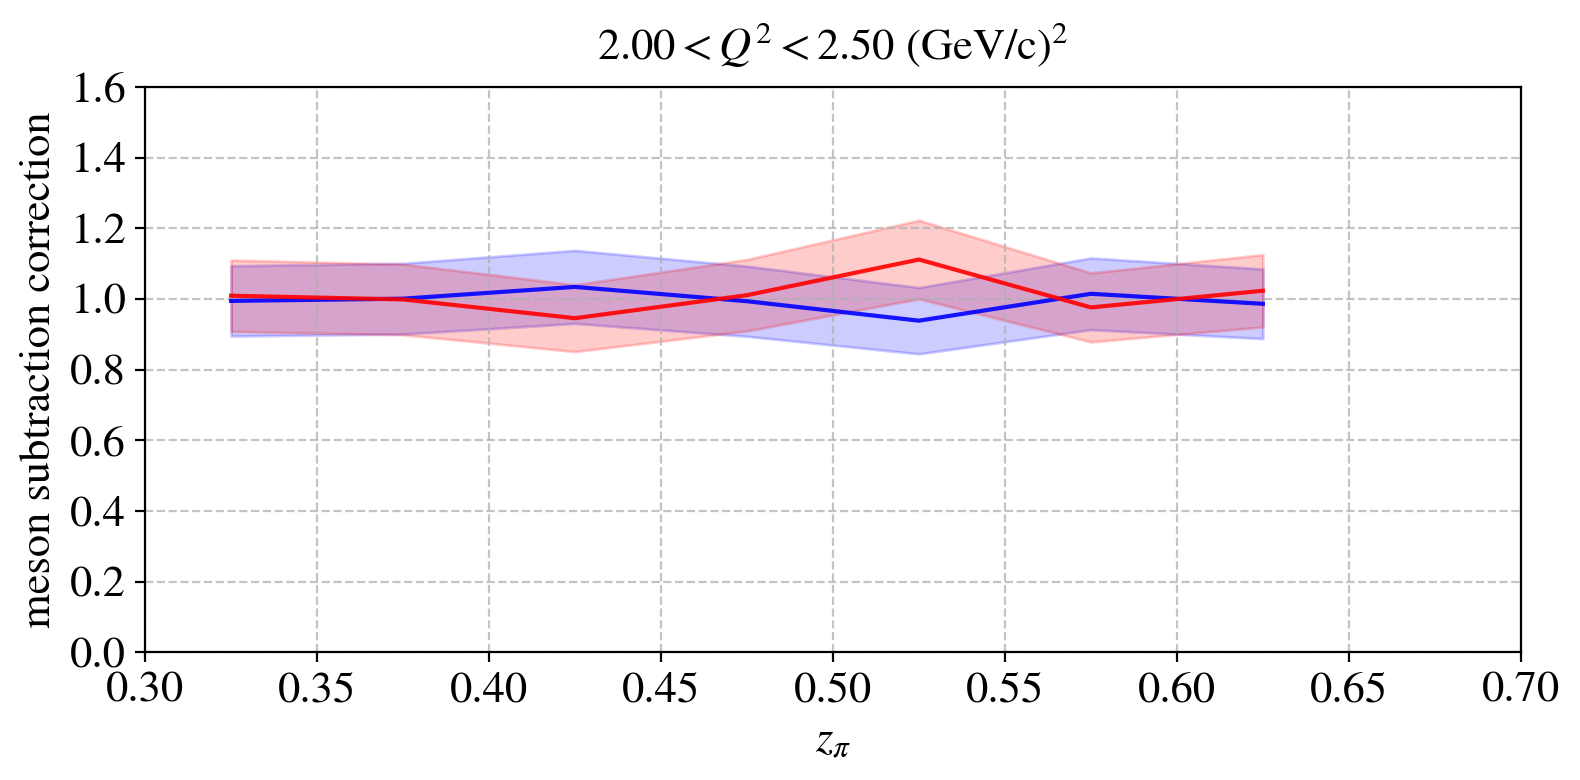

In [61]:
bin_Q2 = 0; Q2_center = MCCorrections_binCenters_Q2[bin_Q2]
Q2_min, Q2_max = Q2_center - MCCorrections_binWidth_Q2/2, Q2_center + MCCorrections_binWidth_Q2/2
bin_x = 4;  xB_center = MCCorrections_binCenters_xB[bin_x]
xB_min, xB_max = xB_center - MCCorrections_binWidth_xB/2, xB_center + MCCorrections_binWidth_xB/2
ylim=(0,1.6)
fig = plt.figure(figsize=(8,4),tight_layout=True)    
ax = fig.add_subplot(1,1,1)

R = BinMigrationWeights['piplus'][bin_x,bin_Q2,:] / BinMigrationWeights['piminus'][bin_x,bin_Q2,:];
r = (4-R)/(4*R-1)
plt.plot( MCCorrections_binCenters_z, R, color='blue', alpha=0.9)
plt.fill_between( MCCorrections_binCenters_z, R-0.1*R, R+0.1*R, color='blue', alpha=0.2)

plt.plot( MCCorrections_binCenters_z, r, color='red', alpha=0.9)
plt.fill_between( MCCorrections_binCenters_z, r-0.1*r, r+0.1*r, color='red', alpha=0.2)



set_axes(ax,'$z_{\pi}$',
         'meson subtraction correction',
         title='$%.2f<Q^2<%.2f$ (GeV/c)$^2$'%(Q2_min, Q2_max),
         xlim=(0.3,0.7), ylim=ylim, do_add_legend=False, do_add_grid=True,fontsize=16,);

### (2.1.3) 2D ($x_B$ vs. $z$ in bins of $Q^2$ and so on..)

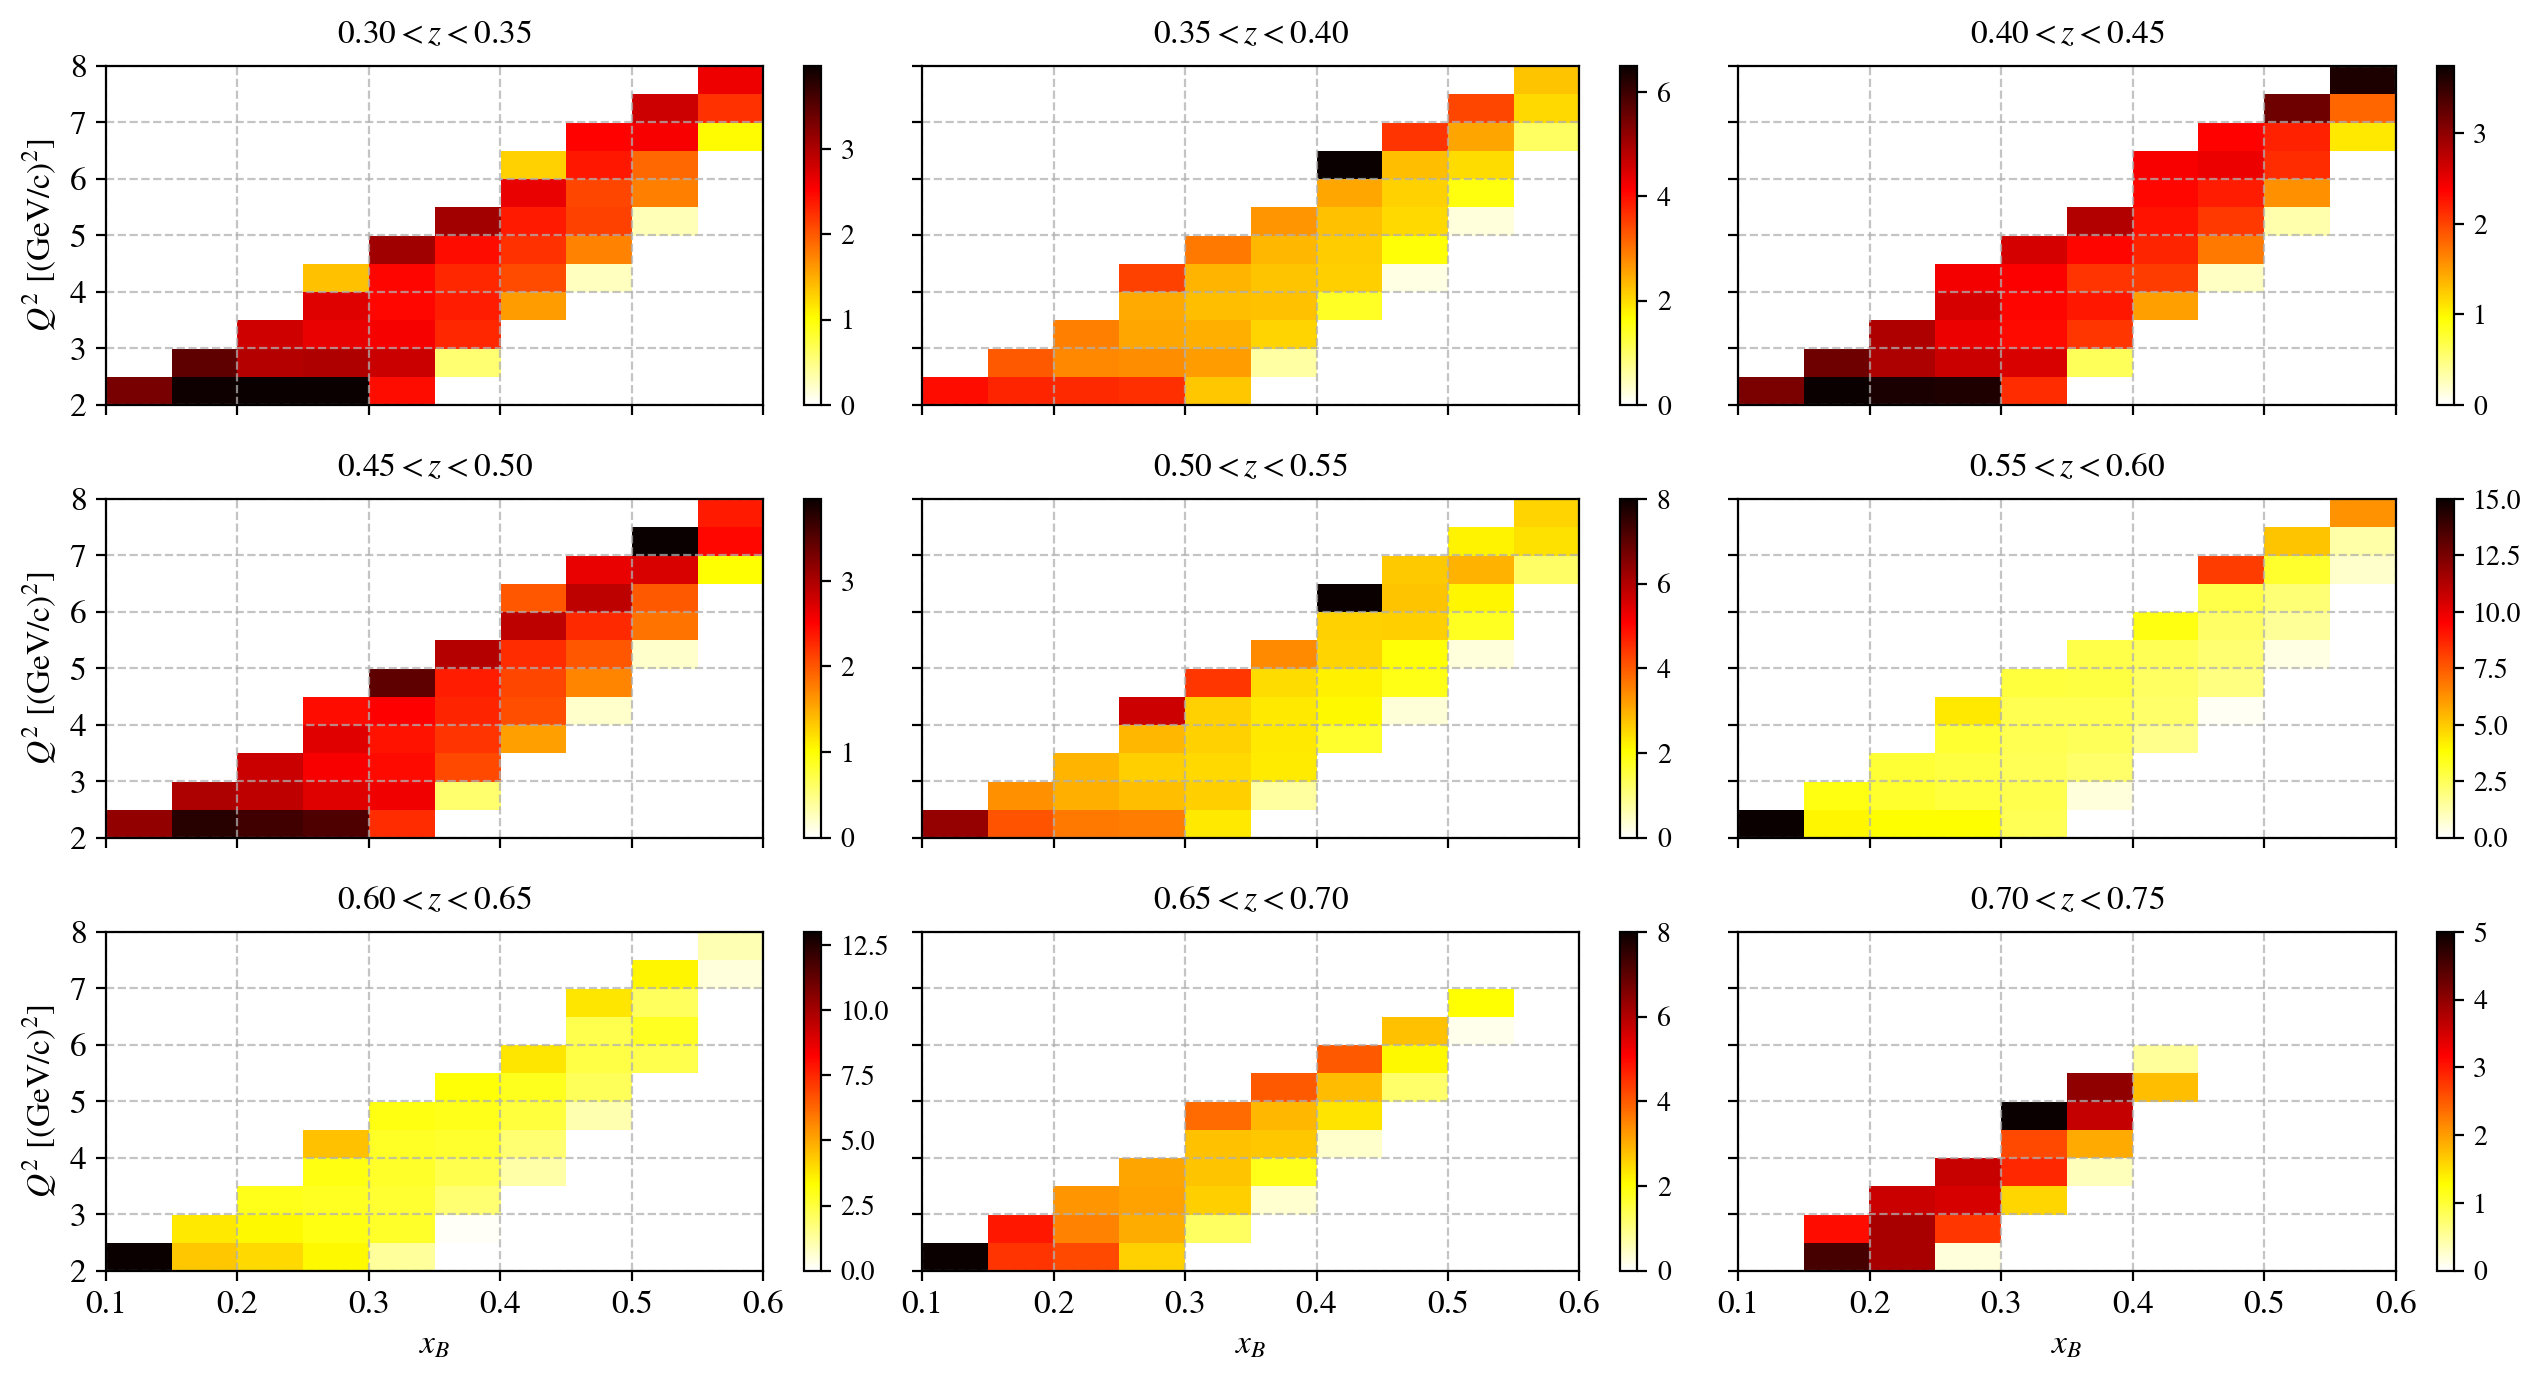

In [132]:
fig = plt.figure(figsize=(13,7),tight_layout=True)
for bin_z in range(9):
    z_center = binCenters_z[bin_z]
    z_min, z_max = z_center - binWidth_z/2, z_center + binWidth_z/2
    
    Corr_xB_Q2 = arr2Plot[:,:,bin_z];
    
    ax = fig.add_subplot(3,3,bin_z+1)        
    im=ax.imshow( Corr_xB_Q2.T, 
                 cmap='hot_r',origin='lower' ,
                 extent=(np.min(MCCorrections_binCenters_xB) - MCCorrections_binWidth_xB/2 ,np.max(MCCorrections_binCenters_xB) + MCCorrections_binWidth_xB/2,
                         np.min(MCCorrections_binCenters_Q2) - MCCorrections_binWidth_Q2/2 ,np.max(MCCorrections_binCenters_Q2) + MCCorrections_binWidth_Q2/2)
                 # vmin=0,vmax=4
                )
    cbar=plt.colorbar(im)
    
    set_axes(ax,'$x_B$' if bin_z>=6 else '',
             '$Q^2$ [(GeV/c)$^2$]' if bin_z%3==0 else '',
             remove_ticks_x=False if bin_z>=6 else True,
             remove_ticks_y=False if bin_z%3==0 else True,
             title='$%.2f<z<%.2f$'%(z_min, z_max),
             xticks=np.arange(0.1,0.65,0.1),
             yticks=np.arange(2,9,1),
             do_add_legend=False,
             do_add_grid=True,fontsize=12)
    

# Define binning 

In [70]:
MCCorrections_binWidth_xB = 0.05;
MCCorrections_binCenters_xB = np.arange(0.125,0.625,0.05); MCCorrections_Nbins_xB = len(MCCorrections_binCenters_xB); 

MCCorrections_binWidth_Q2 = 0.5;
MCCorrections_binCenters_Q2 = np.arange(2.25,8.25,0.5);    MCCorrections_Nbins_Q2 = len(MCCorrections_binCenters_Q2); 

MCCorrections_binWidth_z  = 0.05;
MCCorrections_binCenters_z  = np.arange(0.325,1.025,0.05);  MCCorrections_Nbins_z  = len(MCCorrections_binCenters_z);  

BinMigrationWeights = dict();
AcceptanceWeights   = dict();
BinMigrationWeights['piplus']  = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
BinMigrationWeights['piminus'] = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
AcceptanceWeights['piplus']    = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])
AcceptanceWeights['piminus']   = np.zeros([MCCorrections_Nbins_xB, MCCorrections_Nbins_Q2, MCCorrections_Nbins_z])


In [118]:
MCCorrections_binCenters_xB

array([0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475, 0.525,
       0.575])

# Load Jason calculation results

In [71]:
corrections_data_path = '/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/MC/Acceptance_Corrections/JasonAcceptanceCorrections/'
filename_binmigration_corr_pips = corrections_data_path + 'bin_migration_piplus_hists.root'
filename_binmigration_corr_pims = corrections_data_path + 'bin_migration_piminus_hists.root'
filename_acceptance_corr_pips   = corrections_data_path + 'acceptance_map_piplus_hists.root'
filename_acceptance_corr_pims   = corrections_data_path + 'acceptance_map_piminus_hists.root'

In [72]:
f1 = ROOT.TFile.Open( filename_binmigration_corr_pips,"READ" )
hBinMigrationWeights_pips = f1.Get("hWeights")
f2 = ROOT.TFile.Open( filename_binmigration_corr_pims,"READ" )
hBinMigrationWeights_pims = f2.Get("hWeights")

f3 = ROOT.TFile.Open( filename_acceptance_corr_pips,"READ" )
hAcceptanceWeights_pips = f3.Get("hWeights")
f4 = ROOT.TFile.Open( filename_acceptance_corr_pims,"READ" )
hAcceptanceWeights_pims = f4.Get("hWeights")

In [74]:
for bin_x in range(MCCorrections_Nbins_xB):
    xB = MCCorrections_binCenters_xB[bin_x]
    
    for bin_Q2 in range(MCCorrections_Nbins_Q2):
        Q2 = MCCorrections_binCenters_Q2[bin_Q2]
        
        for bin_z in range(MCCorrections_Nbins_z):
            z = MCCorrections_binCenters_z[bin_z]
            
            # In root, the zeroeth bin is the "underflow bin," so it is not filled. Basically, the first actual bin will have index 1
            BinMigrationWeights['piplus'] [bin_x][bin_Q2][bin_z] = hBinMigrationWeights_pips.GetBinContent(bin_x+1, bin_Q2+1, bin_z+1)
            BinMigrationWeights['piminus'][bin_x][bin_Q2][bin_z] = hBinMigrationWeights_pims.GetBinContent(bin_x+1, bin_Q2+1, bin_z+1)
            AcceptanceWeights['piplus']   [bin_x][bin_Q2][bin_z] = hAcceptanceWeights_pips.GetBinContent  (bin_x+1, bin_Q2+1, bin_z+1)
            AcceptanceWeights['piminus']  [bin_x][bin_Q2][bin_z] = hAcceptanceWeights_pims.GetBinContent  (bin_x+1, bin_Q2+1, bin_z+1)            
            
print('done reading TH3D.')            

done reading TH3D.


## (2.1) Plot bin migration and acceptance weights for $\pi^{\pm}$

In [133]:
arr2Plot = BinMigrationWeights['piplus'];
# arr2Plot = BinMigrationWeights['piminus'];
# arr2Plot = AcceptanceWeights['piplus']
# arr2Plot = AcceptanceWeights['piminus']

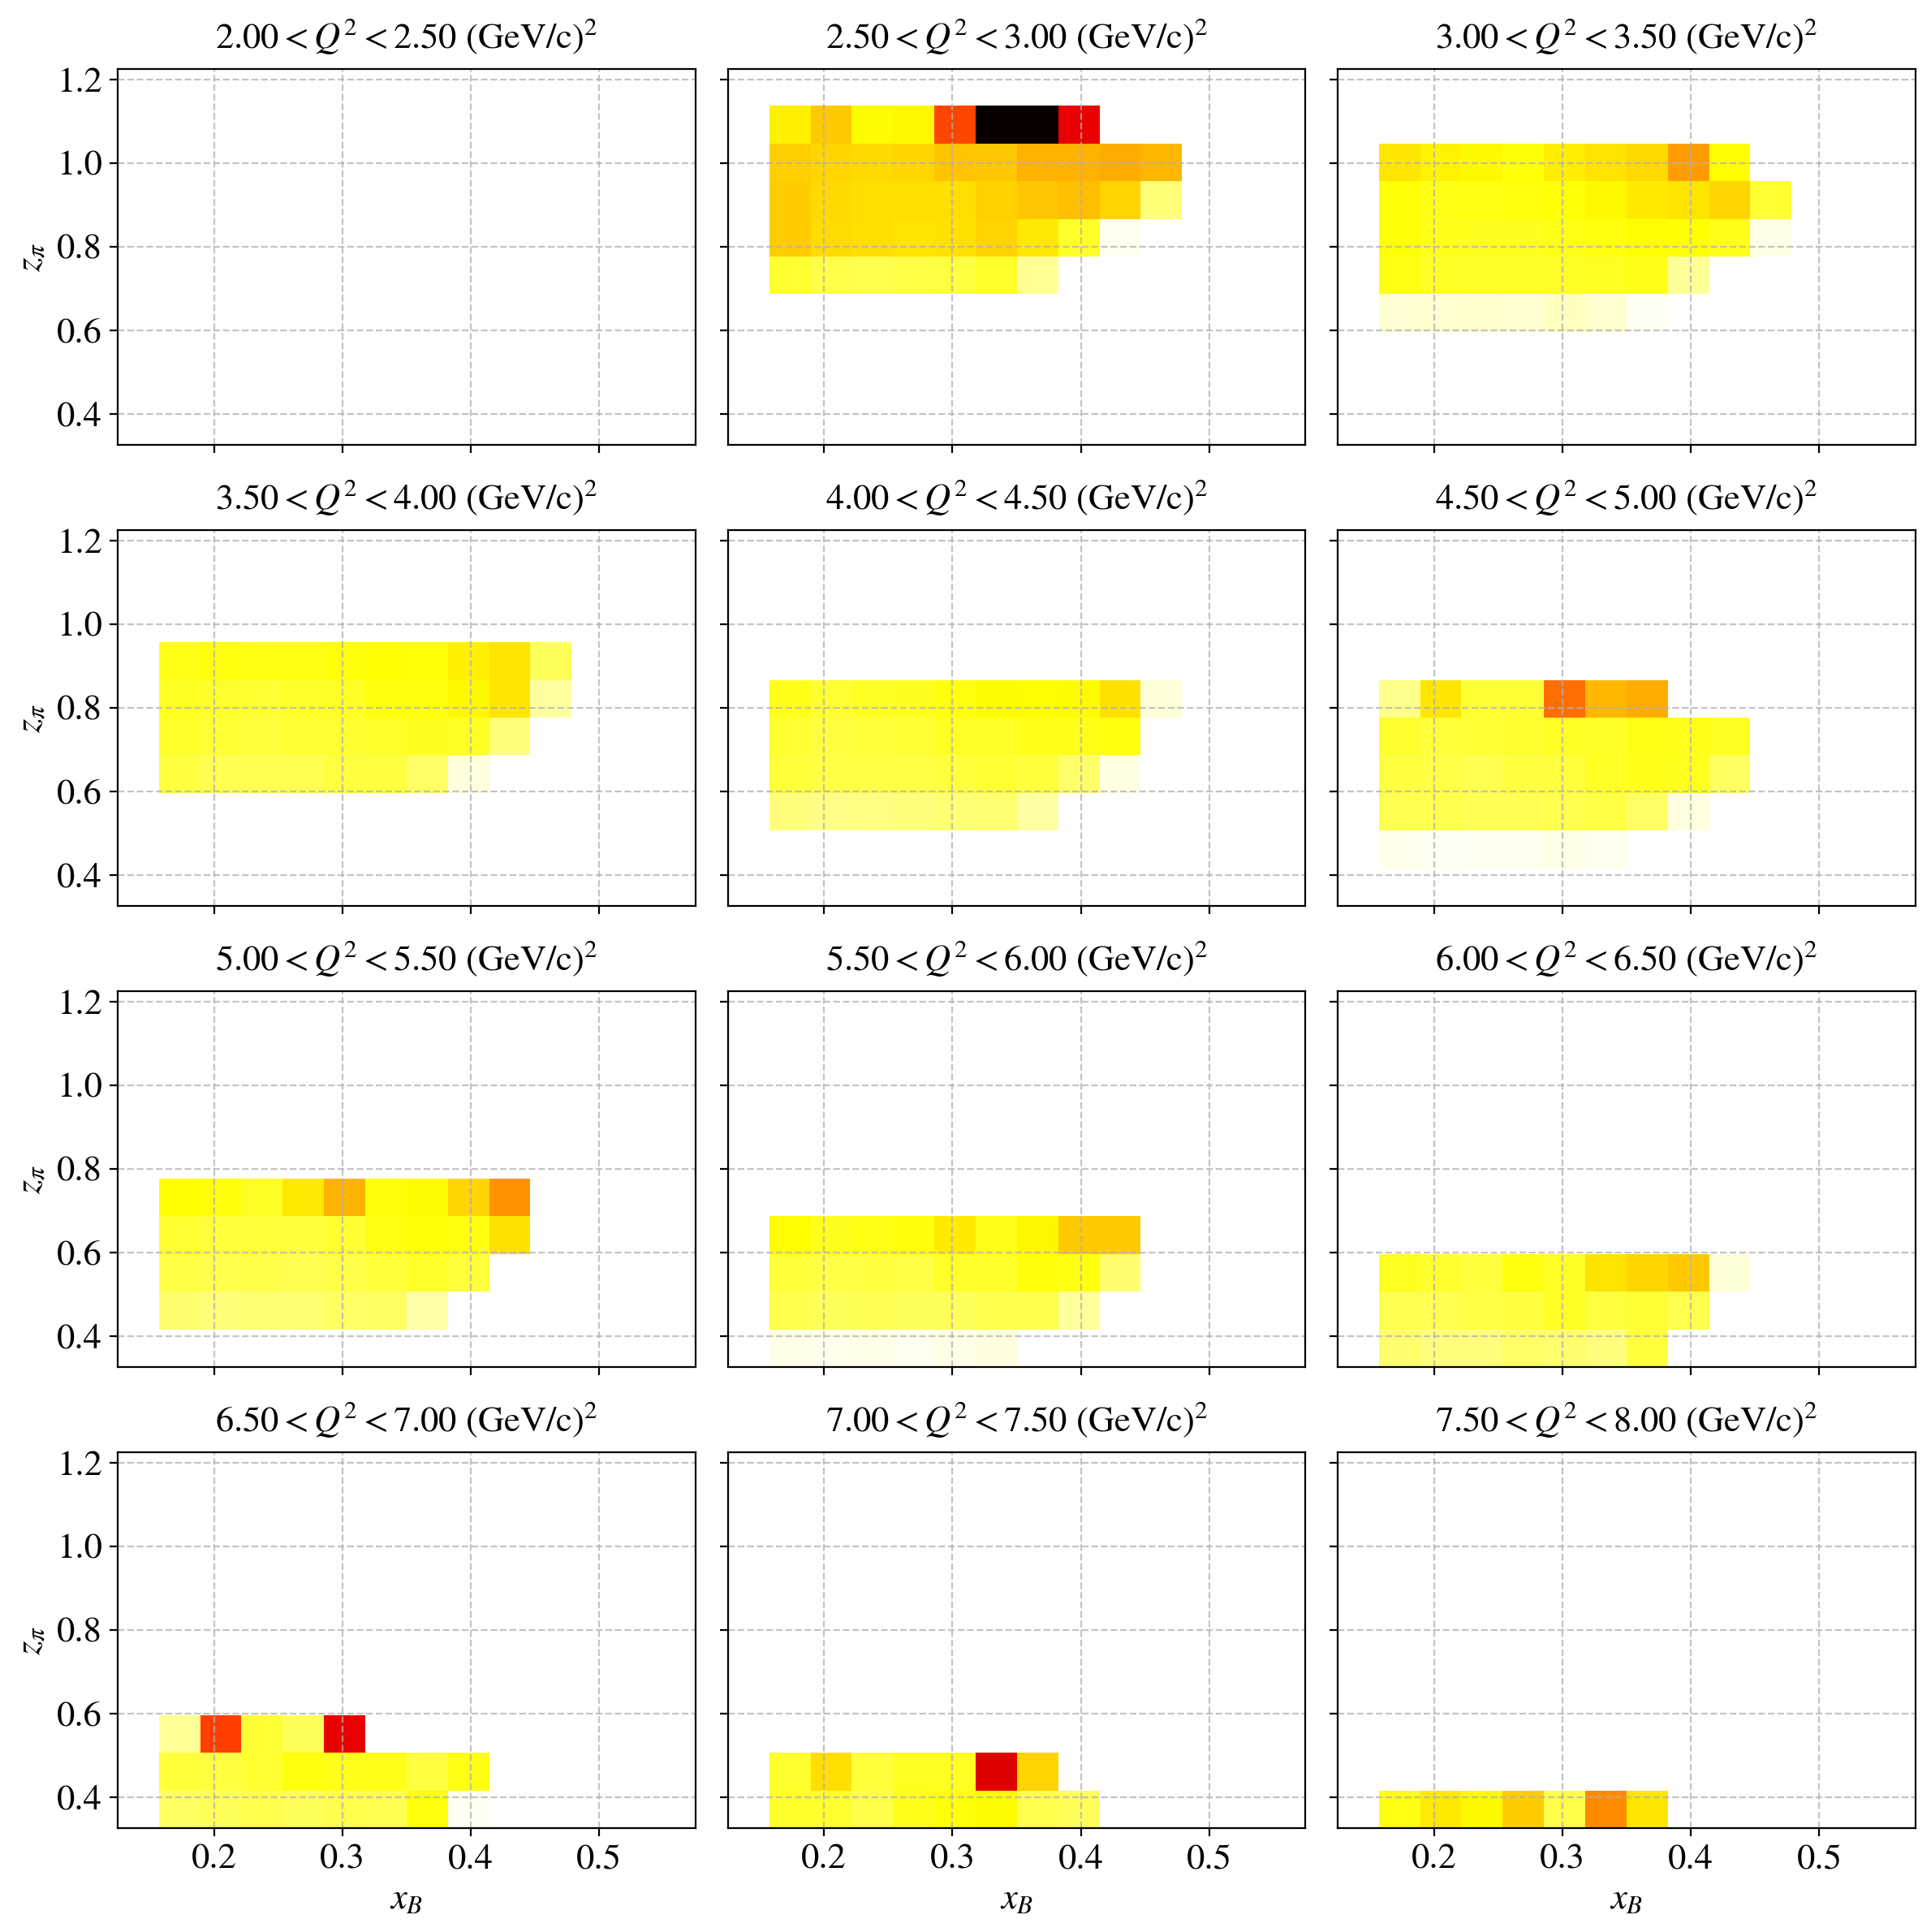

In [38]:
fig = plt.figure(figsize=(12,12),tight_layout=True)
for bin_Q2 in range(MCCorrections_Nbins_Q2):
    Q2_center = binCenters_Q2[bin_Q2]
    Q2_min, Q2_max = Q2_center - binWidth_Q2/2, Q2_center + binWidth_Q2/2
    
    ax = fig.add_subplot(4,3,bin_Q2+1)        
    im=ax.imshow( arr2Plot[:,bin_Q2,:], cmap='hot_r', 
              extent=(np.min(binCenters_xB),np.max(binCenters_xB),
                      np.min(binCenters_z),np.max(binCenters_z)), 
                 vmin=0,vmax=12 )
    # cbar=plt.colorbar(im)
    
    set_axes(ax,'$x_B$' if bin_Q2>=9 else '',
             '$z_{\pi}$' if bin_Q2%3==0 else '',
             remove_ticks_x=False if bin_Q2>=9 else True,
             remove_ticks_y=False if bin_Q2%3==0 else True,
             title='$%.2f<Q^2<%.2f$ (GeV/c)$^2$'%(Q2_min, Q2_max),
             # xlim=(0.3,1),
             do_add_legend=False,
             do_add_grid=True,fontsize=16)
    

In [22]:
MCCorrections_Nbins_z

19